# HOMEWORK PART 1

1. Develop a DMD model to forecast the future population states (note, DMD with two time series can only give you two eigenvalues). Try also bagging the DMD to improve the results. See: https://github.com/duqbo/optdmd (MATLAB) and https://github.com/kunert/py-optDMD (Python)

2. Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables. Try also bagging the DMD to improve the results.

3. Empirical Predator-Prey models such as Lotka-Volterra are commonly used to models such phenomenon.
Consider the model:
\begin{gather*}
\dot{x} = (b-py)x \\
\dot{y} = (rx-d)y
\end{gather*}
Use the data to approximately fit values of b, p, r and d.

4. Find the best fit nonlinear, dynamical systems model to the data using bagging sparse regression SINDy (See: https://github.com/dynamicslab/pysindy/blob/master/examples/13_ensembling.ipynb)

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, splev, splrep
from scipy.linalg import hankel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from scipy import integrate
from Utility.DMDFunctions import DMD, DMDmedium, medium4cast

plt.style.use('science')

In [97]:
path = "../Data/Lynx-Snowshoe.csv"

data = pd.read_csv(path)
data.head()
# data = data.rename(columns={'Year': 'yr', 
#                             'Snowshoe Hare Pelts(thousands)': 'sh', 
#                             'Canadian Lynx Pelts(thousands)': 'cl'})

yr = data['Year']
sh = data['Snowshoe Hare Pelts(thousands)']
cl = data['Canadian Lynx Pelts(thousands)']

dt = 2
time = np.arange(0, max(yr) - min(yr) + dt, dt)

# Request 1

Develop a DMD model to forecast the future population states (note, DMD with two time series can only give you two eigenvalues). Try also bagging the DMD to improve the results. See: https://github.com/duqbo/optdmd (MATLAB) and https://github.com/kunert/py-optDMD (Python)

In [98]:
# Interpolation of the data series, the interpolation with the B-Splne function from SciPy have reasulted in some values lower than 0 replaced here with 1

sh_int = splrep(time, sh)
cl_int = splrep(time, cl)

dt = 0.01

yr_new = np.arange(min(yr), max(yr) + dt, dt)

t_new = np.arange(0, max(yr) - min(yr) + dt, dt)

sh_new = splev(t_new, sh_int)
tmp = sh_new <= 1
sh_new[tmp] = 1

cl_new = splev(t_new, cl_int)
tmp = cl_new <= 1
cl_new[tmp] = 1

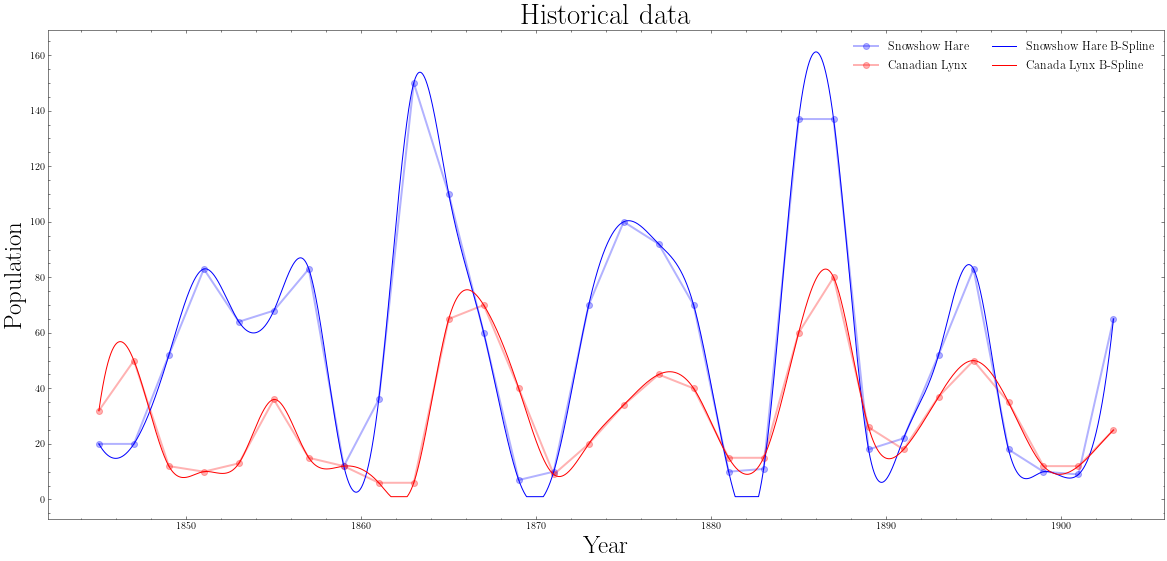

In [99]:
fig = plt.figure(figsize=(20, 9))

plt.plot(yr, sh, '-o', linewidth='2', color='blue', alpha=.3)
plt.plot(yr, cl, '-o', linewidth='2', color='red', alpha=.3)
plt.plot(yr_new, sh_new, color='blue')
plt.plot(yr_new, cl_new, color='red')
plt.title('Historical data', fontsize = 29)
plt.xlabel('Year', fontsize = 25)
plt.ylabel('Population', fontsize = 25)
plt.legend(['Snowshow Hare', 'Canadian Lynx', 'Snowshow Hare B-Spline', 'Canada Lynx B-Spline'], fontsize = 12, ncol=2)

# plt.grid(True, which="both")
fig.savefig('Figures/population_data.pdf', format='pdf', dpi=1200)
plt.show()

In [100]:
tmp_data = np.vstack((sh, cl))
X = tmp_data[:, :-1]
dX = tmp_data[:, 1:]

n_test = int(X.shape[1] * 0.2)

# Train and test
X_train = X[:, :-n_test]
dX_train = dX[:, :-n_test]
X_test = X[:, -n_test:]
dX_test = dX[:, -n_test:]

In [157]:
r = 2
U, S, V, x_dmd = DMD(X, dX, r, time)

print(U)

[[-0.91050967 -0.41348778]
 [-0.41348778  0.91050967]]


In [159]:
r = 2
U,S,V = DMDmedium(X, r)

print(U)

[[ 0.77969621  0.31304729]
 [-0.08895625  0.32353232]]


In [134]:
pred_step = 2
mat_hat = medium4cast(X, r, pred_step)
print(mat_hat)

[[5.83638628 3.91792792]
 [6.49302107 3.80203285]]


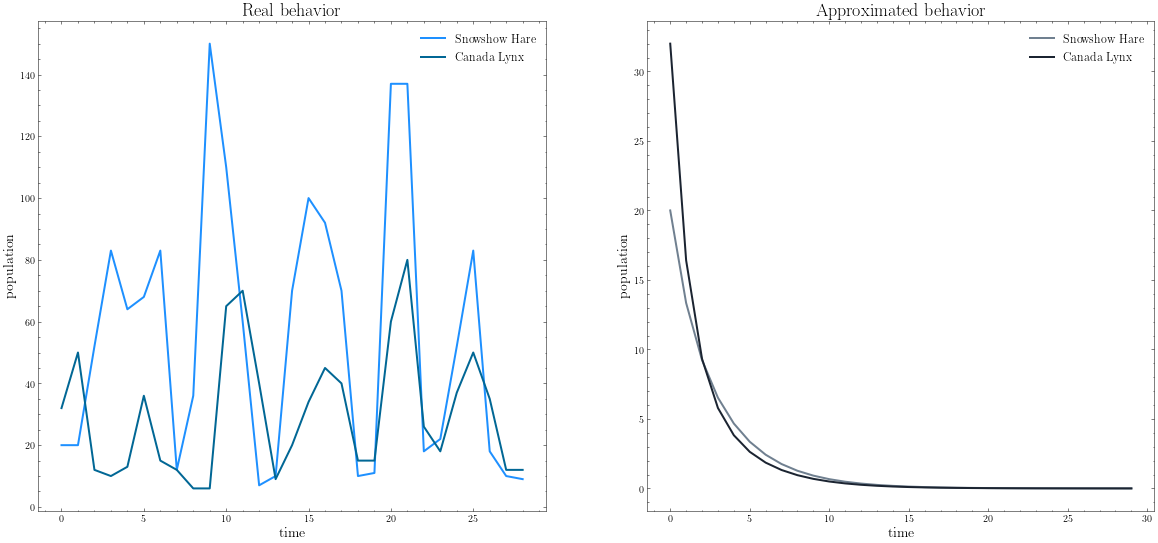

In [160]:
fig = plt.figure(figsize=(20, 9))

ax = plt.subplot(1,2,1)
h = ax.plot(X[0, :], linewidth='2', color='dodgerblue')
h = ax.plot(X[1, :], linewidth='2', color='xkcd:peacock blue')
ax.set_title('Real behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12)

ax = plt.subplot(1,2,2)
h = ax.plot(np.real(x_dmd[0, :]), linewidth='2', color='slategray')
h = ax.plot(np.real(x_dmd[1, :]), linewidth='2', color='xkcd:dark')
ax.set_title('Approximated behavior', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canada Lynx'], fontsize = 12)

plt.show()